Network Analysis of EBMUD Water Distribution System with NetworkX

In [1]:
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
%pip install contextily
import contextily as ctx
%pip install networkx
import networkx as nx
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Read in Data

In [2]:
water_data = gpd.read_file('/home/veronica/data/pipeline_data.geojson')
water_data.head()

OBJECTID  ENABLED  FACILITYID INSTALLDATE STATUSCHANGEDATE LIFECYCLESTATUS  \
0    327273      1.0       19971         NaT             None              AC   
1    327274      1.0       20383         NaT             None              AC   
2    327275      1.0       20377         NaT             None              AC   
3    327276      1.0      103022         NaT             None              AC   
4    327277      1.0      100911         NaT             None              AC   

  WATERTYPE MATERIALTYPE  MGE_MSLINK LININGMATERIALTYPE  ...  ORDERNUMBER  \
0   Potable            A   1015809.0                  U  ...         None   
1   Potable            S   1015849.0                  M  ...         None   
2   Potable            S   1015840.0                  U  ...         None   
3   Potable            A   4061041.0                  U  ...         None   
4   Potable            S   4052734.0                  M  ...         None   

  DISTANCETORW VERTEXCOUNT GEOGRAPHIC_FIDELITY ISHIGHPRESSURE  \
0         None         8.0             Unknown           None   
1         None        12.0             Unknown           None   
2         None         3.0             Unknown           None   
3         None         4.0             Unknown           None   
4         None         2.0             Unknown           None   

   ISRESTRAINEDJOINT PRESPLIT_FACID                                GLOBALID  \
0                NaN        19971.0  {84FFB371-878D-4AC7-A0CC-1FD88A08B718}   
1                NaN        20383.0  {BC267C5B-A5D8-49AF-A5CD-AE45B9F9ECED}   
2                NaN            NaN  {5F8B7A3D-3B96-45B4-A87C-FC5E95614EDA}   
3                NaN       103022.0  {A4E5F113-77D7-4A71-9591-070A5A48411F}   
4                NaN            NaN  {AA23F5C1-7BA2-4D80-9A7C-B26995D9C222}   

   SHAPE_Length                                           geometry  
0     34.586882  MULTILINESTRING ((-122.019 37.81434, -122.0189...  
1      5.085738  MULTILINESTRING ((-122.02131 37.81735, -122.02...  
2     47.460385  MULTILINESTRING ((-122.02007 37.81645, -122.01...  
3      4.558327  MULTILINESTRING ((-122.01905 37.8144, -122.019...  
4     14.561382  MULTILINESTRING ((-122.02085 37.81623, -122.02...  

[5 rows x 52 columns]

In [3]:
# List all columns of the DataFrame
print("Columns in the Water DataFrame:", water_data.columns.tolist())

Columns in the Water DataFrame: ['OBJECTID', 'ENABLED', 'FACILITYID', 'INSTALLDATE', 'STATUSCHANGEDATE', 'LIFECYCLESTATUS', 'WATERTYPE', 'MATERIALTYPE', 'MGE_MSLINK', 'LININGMATERIALTYPE', 'ROUGHNESS', 'ROUGHNESSUNITTYPE', 'COATINGMATERIALTYPE', 'STREETNAME', 'PIPEEXTENSIONNUMBER', 'NOMDIAMUNITTYPE', 'PRESSUREZONE', 'MAINTPRIORITYTYPE', 'INSTALLATIONYEAR', 'HASCULVERTENCASEMENT', 'CULVERTDIAMETER', 'CULVERTDIAMETERUNITTYPE', 'CPSYSTEMOBJECTID', 'CPSYSTEMSTATUS', 'MEASUREDLENGTH', 'OPERATINGPRESSURE', 'WATERTRACEWEIGHT', 'DRAWINGNUMBER', 'CREATIONUSER', 'DATECREATED', 'LASTUSER', 'DATEMODIFIED', 'BASEMAP', 'CITY', 'AQUEDUCT_NAME', 'REPAIR_NUMBER', 'NOMINALDIAMETER', 'RFS_NUMBER', 'OWNED_BY', 'SUBTYPE', 'CASINGTYPE', 'COMMENTS', 'ORDERNUMBER', 'DISTANCETORW', 'VERTEXCOUNT', 'GEOGRAPHIC_FIDELITY', 'ISHIGHPRESSURE', 'ISRESTRAINEDJOINT', 'PRESPLIT_FACID', 'GLOBALID', 'SHAPE_Length', 'geometry']


In [4]:
facilities_data = gpd.read_file('/home/veronica/data/facilities.geojson')
facilities_data.head()

OBJECTID  FAC_GN                          FAC_NM  \
0        25    2736              SCHAPIRO RESERVOIR   
1        26    2762               MALCOLM REGULATOR   
2        27    2740  ROUND HILL NO. 2 PUMPING PLANT   
3        28    2006      LELAND NO. 2 PUMPING PLANT   
4        29    2813         ESTATES NO. 2 RESERVOIR   

                         FAC_ADDR_T  STRCT_NU PRSZ_CD    PRSZ_DESC_  \
0         WEST OF END OF BONITA RD.    2105.0     A2A      Berryman   
1  3698 MALCOLM AVENUE, OAKLAND, CA    2115.0     B5D  Country Club   
2       455 LIVORNA ROAD, ALAMO, CA    2107.0     F7D    Round Hill   
3                  2201 Larkey Ave.    2103.0     H1A        Leland   
4   6317 ESTATES DRIVE, OAKLAND, CA    2116.0     B5A        Dingee   

  PRSZ_HILL_ PRSZ_SRC_C PRSZ_SRC_D  ... FAC_TEMP_F FAC_STBY_F FAC_STAFFE  \
0          W       None       None  ...          N          N          N   
1          W        B3A   Piedmont  ...          N          N          N   
2          E        F5B     Diablo  ...          N          N          N   
3          E        H1A     Leland  ...          N          N          N   
4          W       None       None  ...          N          N          N   

   WTR_TYPE_C        FAC_ABBRV_ MAINT_AREA FAC_NAD83_ FAC_NAD831  \
0           P    SCHAPIRO NO. 2        1.0  6036910.0  2175744.0   
1           P              None        2.0  6087958.0  2098641.0   
2           P  ROUND HILL NO. 2        1.0  6125211.0  2142624.0   
3           P   LELAND NO. 2 PP        1.0  6104610.0  2159586.0   
4           P              None        2.0  6065892.0  2128229.0   

                         STRCT_NM                     geometry  
0              Schapiro Reservoir  POINT (-122.32019 37.95621)  
1         Malcolm No. 2 Regulator  POINT (-122.13848 37.74709)  
2  Round Hill No. 2 Pumping Plant  POINT (-122.01211 37.86959)  
3      Leland No. 2 Pumping Plant  POINT (-122.08446 37.91523)  
4    Estates Reservoir (Proposed)  POINT (-122.21666 37.82725)  

[5 rows x 41 columns]

In [5]:
# List all columns of the DataFrame
print("Columns in the Facilities DataFrame:", facilities_data.columns.tolist())

Columns in the Facilities DataFrame: ['OBJECTID', 'FAC_GN', 'FAC_NM', 'FAC_ADDR_T', 'STRCT_NU', 'PRSZ_CD', 'PRSZ_DESC_', 'PRSZ_HILL_', 'PRSZ_SRC_C', 'PRSZ_SRC_D', 'PLNG_PRSZ_', 'PLNG_PRSZ1', 'FUND_CD', 'FAC_SITE_G', 'FAC_ALT_CD', 'CITY_CD', 'CNTY_CD', 'ZIP_NU', 'FAC_DIRCTN', 'RTU_NM', 'OPS_LOOP_N', 'FAC_TYPE_N', 'FAC_TYPE_A', 'MAP_EAST_N', 'MAP_NORTH_', 'FAC_STAT_C', 'FAC_FAC_ST', 'FAC_FAC__1', 'FAC_PRINT_', 'FAC_FULL_P', 'FAC_LOC_TX', 'FAC_TEMP_F', 'FAC_STBY_F', 'FAC_STAFFE', 'WTR_TYPE_C', 'FAC_ABBRV_', 'MAINT_AREA', 'FAC_NAD83_', 'FAC_NAD831', 'STRCT_NM', 'geometry']


Plot the Data

In [7]:
# Plot data by field of interest

water_data_utm = water_data.to_crs(3857)
fig, ax = plt.subplots(1, figsize=(15,12))

water_data_utm.plot(ax=ax, column='VERTEXCOUNT', categorical=False, cmap='Spectral_r', legend=True)
ctx.add_basemap(ax=ax, crs=3857)

In [8]:
# Create an empty undirected graph in NetworkX
G = nx.Graph()

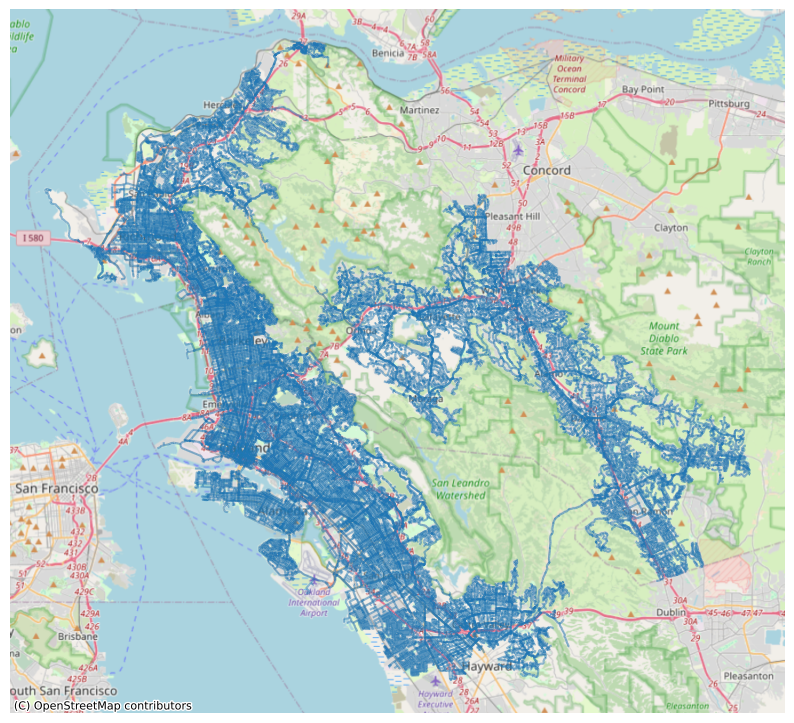

In [9]:
# Create a basemap using contextily
basemap = ctx.providers.OpenStreetMap.Mapnik

# Plot the basemap
ax = water_data.plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, crs=water_data.crs, source=basemap)

# Plot the graph on top of the basemap
pos = {node: node for node in G.nodes()}  # Position the nodes at their coordinates
nx.draw(G, pos, node_size=10, with_labels=False, node_color='b', edge_color='r', ax=ax)

plt.show()

In [10]:
# Extract coordinates from MULTILINESTRING geometries and add edges
for idx, row in water_data.iterrows():
    if row.geometry.type == 'MultiLineString':
        for line in row.geometry.geoms:  # Use .geoms to iterate over LineStrings in MultiLineString
            coords = list(line.coords)
            for i in range(len(coords) - 1):
                start_node = coords[i]
                end_node = coords[i + 1]
                G.add_edge(start_node, end_node)
    elif row.geometry.type == 'LineString':
        coords = list(row.geometry.coords)
        for i in range(len(coords) - 1):
            start_node = coords[i]
            end_node = coords[i + 1]
            G.add_edge(start_node, end_node)

# Check for connected components
G_sort = sorted(nx.connected_components(G), key=len, reverse=True)

if G_sort:
    # Create a subgraph for analysis using the largest connected component
    G_sub = G.subgraph(G_sort[0])
    print("Subgraph created with", len(G_sub.nodes()), "nodes and", len(G_sub.edges()), "edges.")
else:
    print("No connected components found in the graph.")

/tmp/ipykernel_1960810/816292871.py:3: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if row.geometry.type == 'MultiLineString':


Subgraph created with 1351853 nodes and 1364767 edges.


In [11]:
ax_main = water_data.plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax_main, crs=water_data.crs, source=basemap)

# Draw the graph using matplotlib
pos = {node: node for node in G.nodes()}  # Position the nodes at their coordinates
nx.draw(G, pos, with_labels=False, node_size=5)
plt.show()

In [12]:
# Sort the connected components by size in descending order
G_sort = sorted(nx.connected_components(G), key=len, reverse=True)

# Check if there are any connected components
if G_sort:
    # Create a subgraph for analysis using the largest connected component
    G_sub = G.subgraph(G_sort[0])
    print("Subgraph created with", len(G_sub.nodes()), "nodes and", len(G_sub.edges()), "edges.")
else:
    print("No connected components found in the graph.")

Subgraph created with 1351853 nodes and 1364767 edges.


In [13]:
# Plot the basemap
ax = water_data.plot(figsize=(10, 10), alpha=0.5)
ctx.add_basemap(ax, crs=water_data.crs, source=basemap)

# Plot the graph on top of the basemap
pos = {node: node for node in G_sub.nodes()}  # Position the nodes at their coordinates
nx.draw(G_sub, pos, node_size=10, with_labels=False, node_color='b', edge_color='r', ax=ax)

plt.show()

# these mains serve as the network analyzed below

Compute Network Metrics

In [14]:
print("Total Number of Pipes in EBMUD Water Network: ",G.number_of_edges())
print("Number of Pipes in EBMUD Water Subnetwork: ",G_sub.number_of_edges())

Total Number of Pipes in EBMUD Water Network:  1384839
Number of Pipes in EBMUD Water Subnetwork:  1364767


In [15]:
print("Total Number of Nodes in EBMUD Water Network: ",G.number_of_nodes())
print("Number of Nodes in EBMUD Water Subnetwork: ",G_sub.number_of_nodes())

Total Number of Nodes in EBMUD Water Network:  1372418
Number of Nodes in EBMUD Water Subnetwork:  1351853


In [16]:
print("Average degree of EBMUD Water Network = ",2*G.number_of_edges()/G.number_of_nodes())
print("Average degree of EBMUD Water Subnetwork = ",2*G_sub.number_of_edges()/G_sub.number_of_nodes())

Average degree of EBMUD Water Network =  2.018100899288701
Average degree of EBMUD Water Subnetwork =  2.019105627608919


In [17]:
print("Average Clustering Coefficient of EBMUD Water Network = ", nx.average_clustering(G))
print("Average Clustering Coefficient of EBMUD Water Subnetwork = ", nx.average_clustering(G_sub))

Average Clustering Coefficient of EBMUD Water Network =  7.0435294980586575e-06
Average Clustering Coefficient of EBMUD Water Subnetwork =  7.150678858327544e-06


In [18]:
# Compute degree
degrees = dict(G_sub.degree())
min_degree = min(degrees.values())
max_degree = max(degrees.values())
print(f"Minimum degree: {min_degree}")
print(f"Maximum degree: {max_degree}")

# Compute clustering coefficient
clustering_coeffs = nx.clustering(G_sub)
min_clustering = min(clustering_coeffs.values())
max_clustering = max(clustering_coeffs.values())
print(f"Minimum clustering coefficient: {min_clustering}")
print(f"Maximum clustering coefficient: {max_clustering}")

Minimum degree: 1
Maximum degree: 6
Minimum clustering coefficient: 0
Maximum clustering coefficient: 1.0


In [ ]:
# Compute shortest path length
shortest_path_lengths = dict(nx.shortest_path_length(G_sub))
all_lengths = [length for target_lengths in shortest_path_lengths.values() for length in target_lengths.values()]
min_shortest_path = min(all_lengths)
max_shortest_path = max(all_lengths)
print(f"Minimum shortest path length: {min_shortest_path}")
print(f"Maximum shortest path length: {max_shortest_path}")

In [ ]:
# Calculate the average shortest path length for the subgraph
avg_shortest_path_length = nx.average_shortest_path_length(G_sub)
print("Average Shortest Path of EBMUD Water Network =", avg_shortest_path_length)

Analyze Results from NetworKit

In [ ]:
# Read the CSV file
df_bc = pd.read_csv('/home/veronica/data/node_list_dc_btwn.csv')

# Assuming the CSV has a column named 'Betweenness Centrality'
bc_values = df_bc['Betweenness Centrality'].values

In [ ]:
mean_bc = df_bc['Betweenness Centrality'].mean()
mean_bc

np.float64(4334845963.059091)

In [ ]:
max(bc_values)

np.float64(841995273363.3473)

In [ ]:
sorted_bc = df_bc.sort_values(by='Betweenness Centrality', ascending=True)
sorted_bc.head(20000)

Node ID   Longitude   Latitude  Degree Centrality  \
1198746  1198746 -122.189332  37.779898                2.0   
570273    570273 -122.290529  37.831349                1.0   
570222    570222 -122.301759  37.865832                1.0   
570223    570223 -122.301774  37.865829                2.0   
62380      62380 -122.065720  37.920821                1.0   
...          ...         ...        ...                ...   
1272798  1272798 -122.094027  37.691459                2.0   
1272797  1272797 -122.094028  37.691459                2.0   
616982    616982 -122.276122  37.822140                2.0   
616989    616989 -122.276206  37.821800                2.0   
616990    616990 -122.276227  37.821716                2.0   

         Betweenness Centrality  
1198746                     0.0  
570273                      0.0  
570222                      0.0  
570223                      0.0  
62380                       0.0  
...                         ...  
1272798                     0.0  
1272797                     0.0  
616982                      0.0  
616989                      0.0  
616990                      0.0  

[20000 rows x 5 columns]

In [ ]:
# Filter out nodes with zero betweenness centrality
node_list_bc_nozeros = df_bc[df_bc['Betweenness Centrality'] > 0]

# Save the filtered nodes to a new CSV file
node_list_bc_nozeros.to_csv('/home/veronica/data/node_list_bc_nozeros.csv', index=False)

In [ ]:
# Caluclate the logarithm of the betweenness centrality values and add them to the DataFrame

# Define DataFrame
df = node_list_bc_nozeros

# Calculate the logarithm of the betweenness centrality values
df['LogBetweennessCentrality'] = np.log(df['Betweenness Centrality'])

print(df.head())

   Node ID   Longitude   Latitude  Degree Centrality  Betweenness Centrality  \
0        0 -122.019001  37.814343                2.0             256833830.0   
1        1 -122.018985  37.814324                2.0             254130504.0   
2        2 -122.018964  37.814301                2.0             251427174.0   
3        3 -122.018938  37.814276                2.0             248723840.0   
4        4 -122.018928  37.814268                2.0             246020502.0   

   LogBetweennessCentrality  
0                 19.363940  
1                 19.353358  
2                 19.342664  
3                 19.331854  
4                 19.320925  


/tmp/ipykernel_1354077/4272948365.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LogBetweennessCentrality'] = np.log(df['Betweenness Centrality'])


In [ ]:
# save the new DataFrame to a CSV file
df.to_csv('/home/veronica/data/node_list_bc_nozeros_log.csv', index=False)

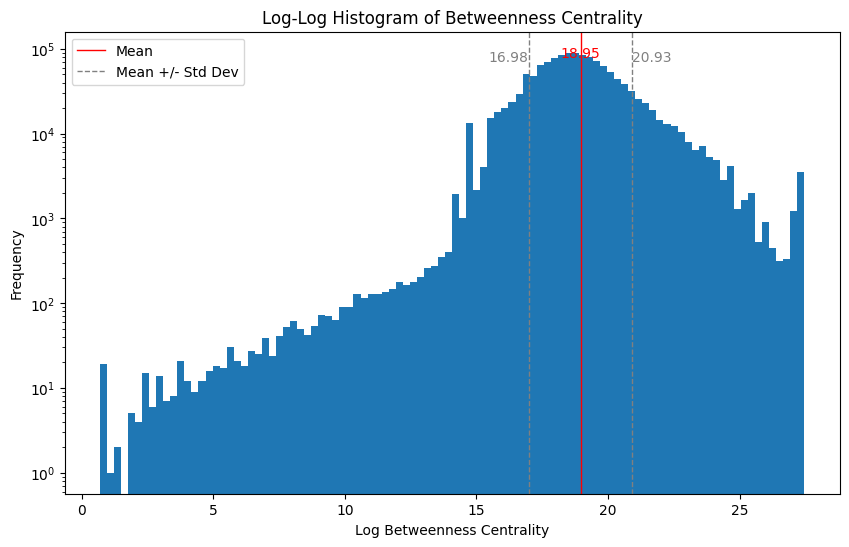

In [ ]:
# Plot log-log histogram of betweenness centrality

# Read the CSV file
df_bc = pd.read_csv('/home/veronica/data/node_list_bc_nozeros_log.csv')

# Assuming the CSV has a column named 'Betweenness Centrality'
bc_values = df_bc['LogBetweennessCentrality'].values

# add mean and standard deviation to the plot
mean_bc = np.mean(bc_values)
std_bc = np.std(bc_values)

# Plot the histogram on a log-log scale
plt.figure(figsize=(10, 6))
plt.hist(bc_values, bins=100, log=True)
plt.axvline(mean_bc, color='r', linestyle='solid', linewidth=1, label='Mean')
plt.axvline(mean_bc + std_bc, color='gray', linestyle='dashed', linewidth=1, label='Mean +/- Std Dev')
plt.axvline(mean_bc - std_bc, color='gray', linestyle='dashed', linewidth=1)
plt.yscale('log')
plt.xlabel('Log Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Log-Log Histogram of Betweenness Centrality')

# Add text annotations for mean and standard deviation
plt.text(mean_bc, plt.ylim()[1] * 0.5, f'{mean_bc:.2f}', color='r', ha='center')
plt.text(mean_bc + std_bc, plt.ylim()[1] * 0.5, f'{mean_bc + std_bc:.2f}', color='gray', ha='left', va='center')
plt.text(mean_bc - std_bc, plt.ylim()[1] * 0.5, f'{mean_bc - std_bc:.2f}', color='gray', ha='right', va='center')

plt.legend()
plt.show()

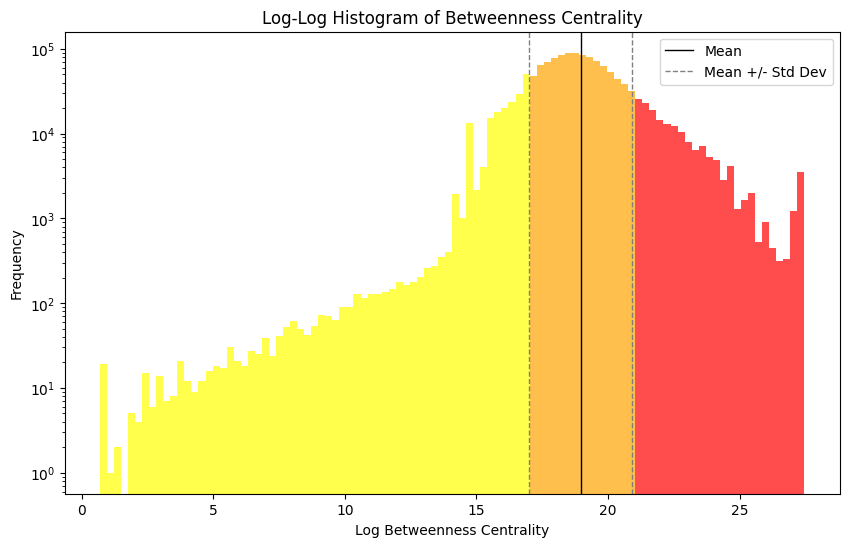

In [ ]:
# Plot log-log histogram of betweenness centrality

# Read the CSV file
df_bc = pd.read_csv('/home/veronica/data/node_list_bc_nozeros_log.csv')

# Assuming the CSV has a column named 'LogBetweennessCentrality'
bc_values = df_bc['LogBetweennessCentrality'].values

# Add mean and standard deviation to the plot
mean_bc = np.mean(bc_values)
std_bc = np.std(bc_values)

# Calculate histogram data
hist, bin_edges = np.histogram(bc_values, bins=100)

# Plot the histogram with different colors
plt.figure(figsize=(10, 6))
for i in range(len(bin_edges) - 1):
    if bin_edges[i] < mean_bc - std_bc:
        color = 'yellow'  # Below mean - std
    elif mean_bc - std_bc <= bin_edges[i] < mean_bc + std_bc:
        color = 'orange'  # Between mean - std and mean + std
    else:
        color = 'red'  # Above mean + std
    plt.bar(bin_edges[i], hist[i], width=bin_edges[i + 1] - bin_edges[i], color=color, align='edge', alpha=0.7)

# Add mean and standard deviation lines
plt.axvline(mean_bc, color='black', linestyle='solid', linewidth=1, label='Mean')
plt.axvline(mean_bc + std_bc, color='gray', linestyle='dashed', linewidth=1, label='Mean +/- Std Dev')
plt.axvline(mean_bc - std_bc, color='gray', linestyle='dashed', linewidth=1)

# Set log scale for y-axis
plt.yscale('log')

# Add labels and title
plt.xlabel('Log Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Log-Log Histogram of Betweenness Centrality')

# Add legend
plt.legend()

# Show the plot
plt.show()

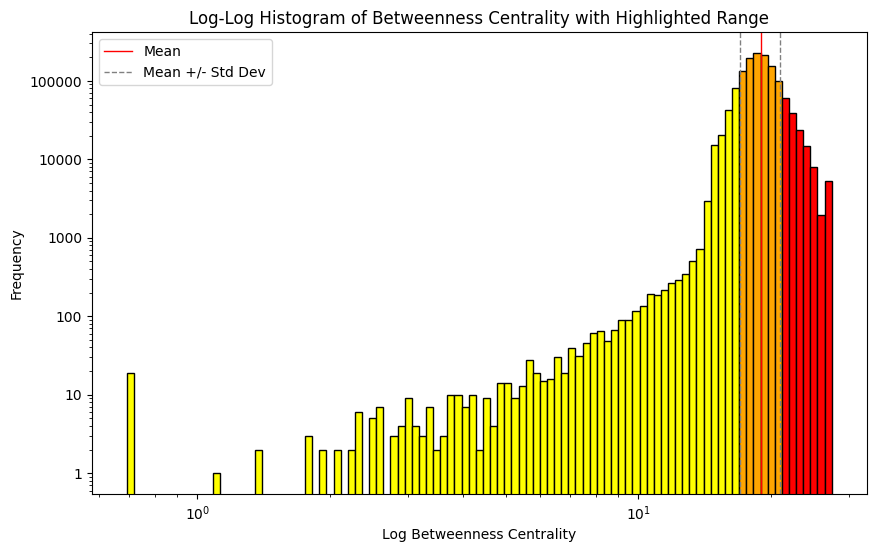

In [ ]:
# Plot log-log histogram of betweenness centrality with shaded bars and numerical y-axis ticks

# Read the CSV file
df_bc = pd.read_csv('/home/veronica/data/node_list_bc_nozeros_log.csv')

# Assuming the CSV has a column named 'Betweenness Centrality'
bc_values = df_bc['LogBetweennessCentrality'].values

# Calculate mean and standard deviation
mean_bc = np.mean(bc_values)
std_bc = np.std(bc_values)

# Define bins for the histogram
bins = np.logspace(np.log10(min(bc_values)), np.log10(max(bc_values)), 100)

# Plot the histogram with custom colors
hist, bin_edges = np.histogram(bc_values, bins=bins)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

colors = []
for center in bin_centers:
    if mean_bc - std_bc <= center <= mean_bc + std_bc:
        colors.append('orange')  # Highlight bars within one standard deviation
    elif center > mean_bc + std_bc:
        colors.append('red')  # Highlight bars above mean + std deviation
    else:
        colors.append('yellow')  # Default color for other bars

plt.figure(figsize=(10, 6))
plt.bar(bin_centers, hist, width=np.diff(bin_edges), color=colors, edgecolor='black', log=True, align='center')

# Add mean and standard deviation lines
plt.axvline(mean_bc, color='r', linestyle='solid', linewidth=1, label='Mean')
plt.axvline(mean_bc + std_bc, color='gray', linestyle='dashed', linewidth=1, label='Mean +/- Std Dev')
plt.axvline(mean_bc - std_bc, color='gray', linestyle='dashed', linewidth=1)

# Set log scale for x-axis
plt.xscale('log')
plt.yscale('log')

# Set numerical values for y-axis ticks
y_ticks = [10**i for i in range(int(np.floor(np.log10(hist.max()))) + 1)]
plt.yticks(y_ticks, labels=[f'{int(tick)}' for tick in y_ticks])

# Add labels and title
plt.xlabel('Log Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Log-Log Histogram of Betweenness Centrality with Highlighted Range')

# Add legend
plt.legend()

plt.show()

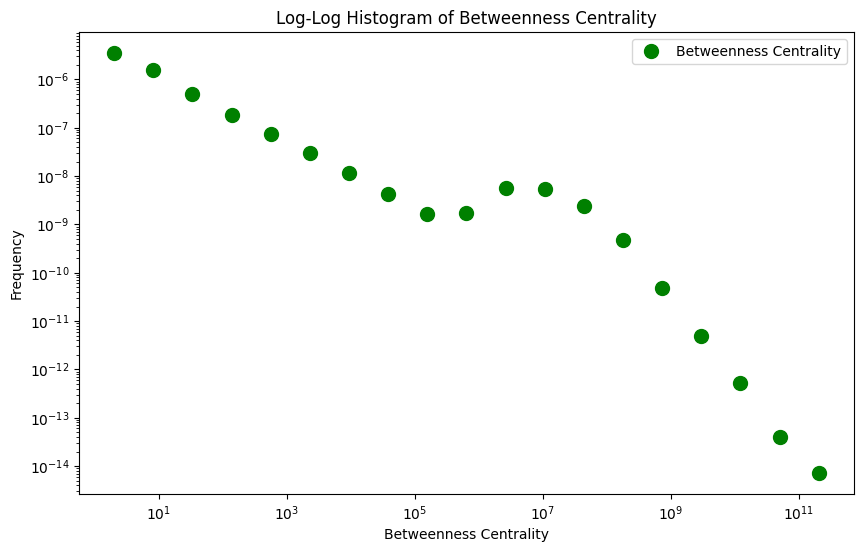

In [ ]:
# Plot log-log histogram of betweenness centrality
import numpy as np

# Read the CSV file
df_bc_nozeros = pd.read_csv('/home/veronica/data/node_list_bc_nozeros.csv')

# Assuming the CSV has a column named 'Betweenness Centrality'
bc_nozeros = df_bc_nozeros['Betweenness Centrality'].values

bin_edges = np.logspace(np.log10(min(bc_nozeros)), np.log10(max(bc_nozeros)), num=20)
n2, bins2 = np.histogram(bc_nozeros, bin_edges, density= True)

# Plot the histogram on a log-log scale
plt.figure(figsize=(10, 6))
plt.loglog(bins2[:-1], n2, 'go', markersize=10, label="Betweenness Centrality")
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.title('Log-Log Histogram of Betweenness Centrality')
plt.legend()
plt.show()

Plot Log-log scatter plot of Betweenness Centrality and Income Demographics

Plot with zero betweenness centralities

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Read the CSV file containing node coordinates and betweenness centrality
df_nodes = pd.read_csv('/home/veronica/data/node_list_dc_btwn.csv')

# Read the shapefile containing census tract locations and income values
gdf_census = gpd.read_file('/home/veronica/data/shapefiles/EBMUD_ServiceCounties/ContraCosta_Alameda_tracts.shp')

# Assuming the CSV file has the following columns:
# df_nodes: 'Node', 'Betweenness Centrality', 'Latitude', 'Longitude'
# gdf_census: 'Tract', 'Name', 'B01003_001', 'B19013_001', 'geometry'

# Create a GeoDataFrame for the nodes
geometry = [Point(xy) for xy in zip(df_nodes['Longitude'], df_nodes['Latitude'])]
gdf_nodes = gpd.GeoDataFrame(df_nodes, geometry=geometry)

# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
gdf_nodes = gdf_nodes.set_crs(gdf_census.crs, allow_override=True)

# Perform a spatial join to match nodes to the census tracts
gdf_nodes = gpd.sjoin(gdf_nodes, gdf_census, how='left', predicate='within')

# Check if the values are assigned correctly
print(gdf_nodes.head())

   Node ID   Longitude   Latitude  Degree Centrality  Betweenness Centrality  \
0        0 -122.019001  37.814343                2.0             256833830.0   
1        1 -122.018985  37.814324                2.0             254130504.0   
2        2 -122.018964  37.814301                2.0             251427174.0   
3        3 -122.018938  37.814276                2.0             248723840.0   
4        4 -122.018928  37.814268                2.0             246020502.0   

                      geometry  index_right STATE COUNTY   TRACT  \
0    POINT (-122.019 37.81434)        467.0    06    013  345203   
1  POINT (-122.01899 37.81432)        467.0    06    013  345203   
2   POINT (-122.01896 37.8143)        467.0    06    013  345203   
3  POINT (-122.01894 37.81428)        467.0    06    013  345203   
4  POINT (-122.01893 37.81427)        467.0    06    013  345203   

                                                NAME  B01003_001  B19013_001  \
0  Census Tract 3452.03, Contr

In [ ]:
# save the joined data to a new CSV file
gdf_nodes.to_csv('/home/veronica/data/nodes_census_joined.csv', index=False)

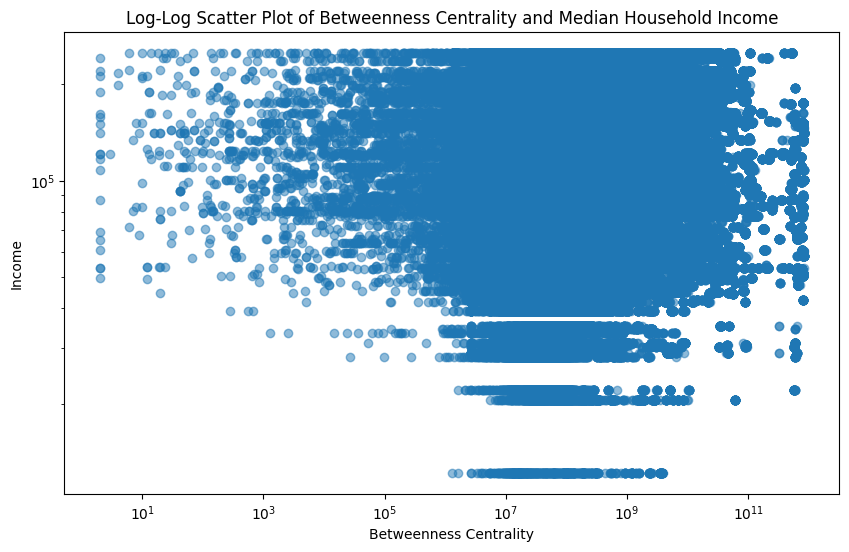

In [ ]:
# Extract betweenness centrality and income values
bc_values = gdf_nodes['Betweenness Centrality'].values
income_values = gdf_nodes['B19013_001'].values

# Plot the scatter plot on a log-log scale
plt.figure(figsize=(10, 6))
plt.scatter(bc_values, income_values, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Income')
plt.title('Log-Log Scatter Plot of Betweenness Centrality and Median Household Income')
plt.show()

Plot without zero betweenness centralities

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Read the CSV file containing node coordinates and betweenness centrality
df_nodes_nz = pd.read_csv('/home/veronica/data/node_list_bc_nozeros.csv')

# Read the shapefile containing census tract locations and income values
gdf_census = gpd.read_file('/home/veronica/data/shapefiles/EBMUD_ServiceCounties/ContraCosta_Alameda_tracts.shp')

# Assuming the CSV file has the following columns:
# df_nodes: 'Node', 'Betweenness Centrality', 'Latitude', 'Longitude'
# gdf_census: 'Tract', 'Name', 'B01003_001', 'B19013_001', 'geometry'

# Create a GeoDataFrame for the nodes
geometry_nz = [Point(xy) for xy in zip(df_nodes_nz['Longitude'], df_nodes_nz['Latitude'])]
gdf_nodes_nz = gpd.GeoDataFrame(df_nodes_nz, geometry=geometry_nz)

# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
gdf_nodes_nz = gdf_nodes_nz.set_crs(gdf_census.crs, allow_override=True)

# Perform a spatial join to match nodes to the census tracts
gdf_nodes_nz = gpd.sjoin(gdf_nodes_nz, gdf_census, how='left', predicate='within')

# Check if the values are assigned correctly
print(gdf_nodes_nz.head())

   Node ID   Longitude   Latitude  Degree Centrality  Betweenness Centrality  \
0        0 -122.019001  37.814343                2.0             256833830.0   
1        1 -122.018985  37.814324                2.0             254130504.0   
2        2 -122.018964  37.814301                2.0             251427174.0   
3        3 -122.018938  37.814276                2.0             248723840.0   
4        4 -122.018928  37.814268                2.0             246020502.0   

                      geometry  index_right STATE COUNTY   TRACT  \
0    POINT (-122.019 37.81434)        467.0    06    013  345203   
1  POINT (-122.01899 37.81432)        467.0    06    013  345203   
2   POINT (-122.01896 37.8143)        467.0    06    013  345203   
3  POINT (-122.01894 37.81428)        467.0    06    013  345203   
4  POINT (-122.01893 37.81427)        467.0    06    013  345203   

                                                NAME  B01003_001  B19013_001  \
0  Census Tract 3452.03, Contr

In [ ]:
# save the joined data to a new CSV file
gdf_nodes_nz.to_csv('/home/veronica/data/nodes_census_joined_nozeros.csv', index=False)

/data_1/veronica/myenv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


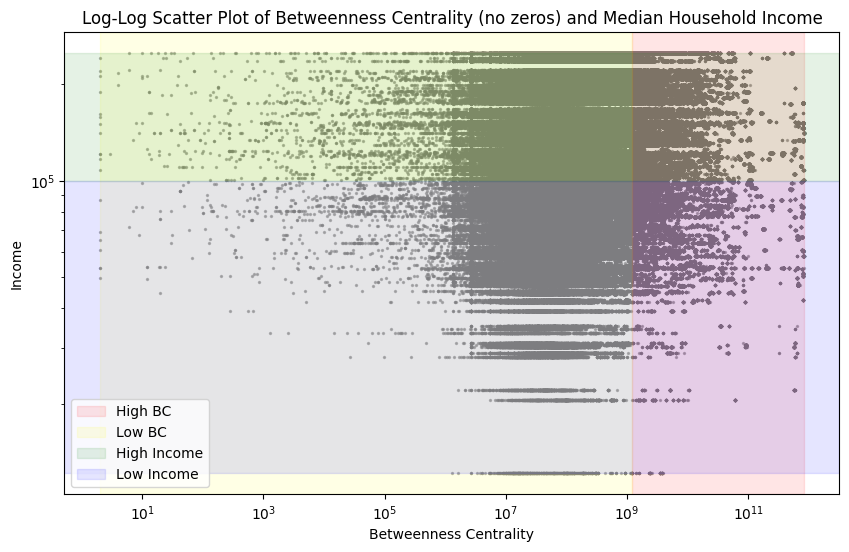

In [ ]:
# Extract betweenness centrality and income values
bc_values_nz = gdf_nodes_nz['Betweenness Centrality'].values
income_values_nz = gdf_nodes_nz['B19013_001'].values

# Define thresholds for income and betweenness centrality
income_threshold = 100000  # low-income threshold for average size household
bc_threshold = np.exp(mean_bc + std_bc)       # high betweenness centrality threshold for nodes

# Plot the scatter plot on a log-log scale
plt.figure(figsize=(10, 6))
plt.scatter(bc_values_nz, income_values_nz, alpha=0.5, color = 'gray', s=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Income')
plt.title('Log-Log Scatter Plot of Betweenness Centrality (no zeros) and Median Household Income')

# Add shaded quadrants
plt.axvspan(bc_threshold, max(bc_values_nz), ymin=0, ymax=1, color='red', alpha=0.1, label='High BC')
plt.axvspan(min(bc_values_nz), bc_threshold, ymin=0, ymax=1, color='yellow', alpha=0.1, label='Low BC')
plt.axhspan(income_threshold, max(income_values_nz), xmin=0, xmax=1, color='green', alpha=0.1, label='High Income')
plt.axhspan(min(income_values_nz), income_threshold, xmin=0, xmax=1, color='blue', alpha=0.1, label='Low Income')

plt.legend()
plt.show()

In [ ]:
# Categorize each node by quadrant
def categorize_node(row):
    if row['Betweenness Centrality'] >= bc_threshold and row['B19013_001'] >= income_threshold:
        return 'High BC, High Income'
    elif row['Betweenness Centrality'] >= bc_threshold and row['B19013_001'] < income_threshold:
        return 'High BC, Low Income'
    elif row['Betweenness Centrality'] < bc_threshold and row['B19013_001'] >= income_threshold:
        return 'Low BC, High Income'
    else:
        return 'Low BC, Low Income'

gdf_nodes_nz['Category'] = gdf_nodes_nz.apply(categorize_node, axis=1)

# Save the categorized data to a new CSV file
gdf_nodes_nz.to_csv('/home/veronica/data/nodes_categorized.csv', index=False)

# Check if the values are assigned correctly
print(gdf_nodes_nz.head())

   Node ID   Longitude   Latitude  Degree Centrality  Betweenness Centrality  \
0        0 -122.019001  37.814343                2.0             256833830.0   
1        1 -122.018985  37.814324                2.0             254130504.0   
2        2 -122.018964  37.814301                2.0             251427174.0   
3        3 -122.018938  37.814276                2.0             248723840.0   
4        4 -122.018928  37.814268                2.0             246020502.0   

                      geometry  index_right STATE COUNTY   TRACT  \
0    POINT (-122.019 37.81434)        467.0    06    013  345203   
1  POINT (-122.01899 37.81432)        467.0    06    013  345203   
2   POINT (-122.01896 37.8143)        467.0    06    013  345203   
3  POINT (-122.01894 37.81428)        467.0    06    013  345203   
4  POINT (-122.01893 37.81427)        467.0    06    013  345203   

                                                NAME  B01003_001  B19013_001  \
0  Census Tract 3452.03, Contr